In [21]:
import numpy as np
import pandas as pd
import uproot
from tqdm.auto import tqdm
import hist
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)

In [32]:
input_base = "/scratch/cuisset/cmt/MergeCategorization/ul_2018_ZbbHtt_v12/%(dataset)s/%(category)s/prod_240522/data_0.root"
category = "cat_ZbbHtt_orthogonal_cut_90_resolved_2b"
signal = "zh_zbb_htt_signal"
bkgs = ["dy"]
weights   = ['genWeight', 'puWeight', 'prescaleWeight', 'trigSF', 'PUjetID_SF']

In [33]:
def read_root_file(filename, tree_name="Events", features=["event", "dnn_ZHbbtt_kl_1"]+weights):
    root_file = uproot.open(filename)
    try:
        tree = root_file[tree_name]
        return tree.arrays(features, library="pd")
    except uproot.exceptions.KeyInFileError:
        print(f"'{tree_name}' does not exist in the ROOT file: {filename}.")

In [34]:
signal_df = read_root_file(input_base % dict(dataset=signal, category=category))
bkg_dfs = [read_root_file(input_base % dict(dataset=bkg_dataset, category=category)) for bkg_dataset in bkgs]

In [35]:
signal_df

,event,dnn_ZHbbtt_kl_1,genWeight,puWeight,prescaleWeight,trigSF,PUjetID_SF
0,373620,0.880733,0.838428,1.028189,1.0,0.966192,0.978286
1,1463334,0.990703,0.838428,1.005130,1.0,0.975383,0.991965
2,1465927,0.886165,0.838428,1.095101,1.0,1.003743,0.996979
3,1472667,0.708676,0.838428,0.966409,1.0,1.000000,0.964508
4,1481482,0.763170,0.838428,0.979784,1.0,0.863615,0.997191
...,...,...,...,...,...,...,...
11545,2441689,0.905677,0.838428,0.918711,1.0,0.963186,0.996654
11546,2016319,0.989982,0.838428,0.987396,1.0,0.915652,0.984371
11547,4766721,0.990716,0.838428,0.981291,1.0,0.996068,0.998588
11548,2234833,0.835039,0.838428,1.058484,1.0,0.988938,0.996979


In [36]:
df = pd.concat([signal_df, *bkg_dfs], keys=["signal", *bkg]).reset_index(0)
df

,level_0,event,dnn_ZHbbtt_kl_1,genWeight,puWeight,prescaleWeight,trigSF,PUjetID_SF
0,signal,373620,0.880733,0.838428,1.028189,1.0,0.966192,0.978286
1,signal,1463334,0.990703,0.838428,1.005130,1.0,0.975383,0.991965
2,signal,1465927,0.886165,0.838428,1.095101,1.0,1.003743,0.996979
3,signal,1472667,0.708676,0.838428,0.966409,1.0,1.000000,0.964508
4,signal,1481482,0.763170,0.838428,0.979784,1.0,0.863615,0.997191
...,...,...,...,...,...,...,...,...
1171,dy,35380617,0.967411,-25259.673828,1.011662,1.0,0.959294,0.998894
1172,dy,114436617,0.864579,25259.673828,0.992865,1.0,0.979107,0.996066
1173,dy,15048445,0.877574,25259.673828,1.005130,1.0,0.975383,0.994972
1174,dy,137519085,0.920032,25259.673828,0.918711,1.0,0.984806,0.998588


In [37]:
pred_name = "dnn_ZHbbtt_kl_1"
class_name = "level_0"
edges,ub,lb = [1.],1.,0.
step_sz = 0.01
max_unc = 0.2
n_min = int((1/max_unc)**2)
print(n_min)
for i in tqdm(np.linspace(ub,lb+step_sz, int((ub-lb)/step_sz))):
    cut = (df[pred_name] > i) & (df[pred_name] <= edges[-1])
    pops = [len(df[(df[class_name] == c) & cut]) for c in df[class_name].unique()]
    if np.min(pops) >= n_min: edges.append(i)
edges.append(0)
res_edges = np.sort(edges)
res_edges

25


  0%|          | 0/100 [00:00<?, ?it/s]

array([0.  , 0.02, 0.1 , 0.16, 0.21, 0.27, 0.32, 0.37, 0.41, 0.46, 0.49,
       0.53, 0.56, 0.6 , 0.63, 0.65, 0.68, 0.71, 0.73, 0.76, 0.79, 0.81,
       0.83, 0.85, 0.86, 0.87, 0.89, 0.9 , 0.92, 0.94, 0.95, 0.96, 0.97,
       0.98, 1.  ])

In [38]:
dnn_axis = hist.axis.Variable(res_edges, name="dnn")
h_sig = hist.Hist(dnn_axis, name="signal")
h_sig.fill(df[pred_name][df[class_name] == "signal"])
h_bkgs = [hist.Hist(dnn_axis, name=bkg_dataset).fill(df[pred_name][df[class_name] == bkg_dataset]) for bkg_dataset in bkgs]
h_bkgs[0]

Hist(Variable(array([0.  , 0.02, 0.1 , 0.16, 0.21, 0.27, 0.32, 0.37, 0.41, 0.46, 0.49,
       0.53, 0.56, 0.6 , 0.63, 0.65, 0.68, 0.71, 0.73, 0.76, 0.79, 0.81,
       0.83, 0.85, 0.86, 0.87, 0.89, 0.9 , 0.92, 0.94, 0.95, 0.96, 0.97,
       0.98, 1.  ]), name='dnn'), storage=Double()) # Sum: 1149.0 (1176.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2919bb15d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

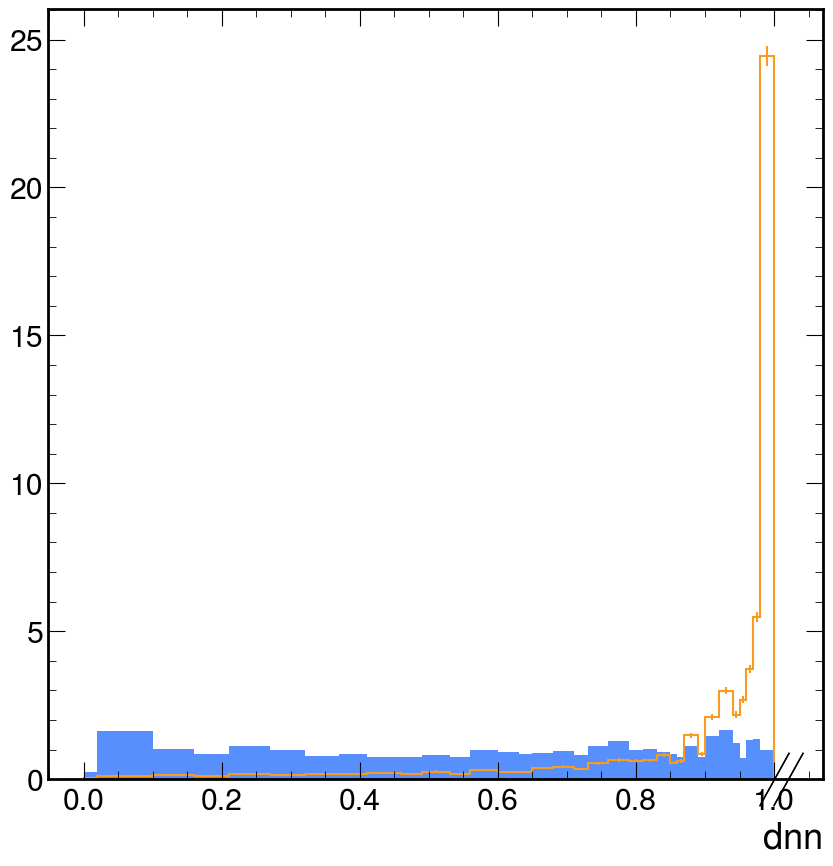

In [39]:
hep.histplot(h_bkgs, stack=True, histtype="fill", density=True)
hep.histplot(h_sig, density=True)